# Uplift

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from pathlib import Path

from sklearn.model_selection import train_test_split

from lightgbm import LGBMClassifier

from sklift.models import ClassTransformation, TwoModels
from sklift.metrics import qini_auc_score, uplift_at_k

import warnings
warnings.filterwarnings("ignore")


In [2]:
RAW  = Path("../data/raw")
PROC = Path("../data/processed")

pp = joblib.load(PROC / "preprocessor.pkl")

num_cols = list(pp.transformers_[0][2])
cat_cols = list(pp.transformers_[1][2])
use_cols = num_cols + cat_cols

df = pd.read_parquet(RAW / "orange_belgium_std.parquet")

if "treatment" not in df.columns and "t" in df.columns:
    df = df.rename(columns={"t": "treatment"})

assert {"churn","treatment"}.issubset(df.columns), "Нужны столбцы churn и treatment"

y = df["churn"].astype(int).to_numpy()
t = df["treatment"].astype(int).to_numpy()
X = df[use_cols].copy()

X_proc = pp.transform(X)

print("Shapes:", X_proc.shape, y.shape, t.shape)
print("Churn rate:", y.mean(), "| Treatment share:", t.mean())


Shapes: (11896, 335) (11896,) (11896,)
Churn rate: 0.03429724277067922 | Treatment share: 0.7573974445191661


In [3]:
strata = y * 2 + t

X_tr, X_te, y_tr, y_te, t_tr, t_te = train_test_split(
    X_proc, y, t, test_size=0.2, stratify=strata, random_state=42
)

print("Train:", X_tr.shape, "Test:", X_te.shape)

Train: (9516, 335) Test: (2380, 335)


In [4]:
ct = ClassTransformation(
    estimator=LGBMClassifier(
        n_estimators=600, learning_rate=0.05, num_leaves=31,
        random_state=42, verbose=-1, n_jobs=-1
    )
)
ct.fit(X_tr, y_tr, t_tr)
uplift_ct = ct.predict(X_te) 
uplift_ct[:5]


array([-0.58308651, -0.15824994, -0.70741343, -0.72239979, -0.73825218])

In [5]:
tm = TwoModels(
    estimator_trmnt=LGBMClassifier(n_estimators=600, learning_rate=0.05, num_leaves=31,
                                   random_state=42, verbose=-1, n_jobs=-1),
    estimator_ctrl=LGBMClassifier(n_estimators=600, learning_rate=0.05, num_leaves=31,
                                  random_state=42, verbose=-1, n_jobs=-1),
    method='vanilla'
)
tm.fit(X_tr, y_tr, t_tr)
uplift_tm = tm.predict(X_te)
uplift_tm[:5]

array([ 3.69917979e-06, -6.19569357e-07, -9.29268863e-09, -8.83155726e-07,
       -1.92617860e-05])

In [6]:
rows = []
for name, scores in [("CT", uplift_ct), ("TwoModels", uplift_tm)]:
    q  = qini_auc_score(y_te, scores, t_te)
    u5 = uplift_at_k(y_te, scores, t_te, strategy='overall', k=0.05)
    u1 = uplift_at_k(y_te, scores, t_te, strategy='overall', k=0.10)
    u2 = uplift_at_k(y_te, scores, t_te, strategy='overall', k=0.20)
    rows.append(dict(model=name, qini_auc=q, uplift_5=u5, uplift_10=u1, uplift_20=u2))

pd.DataFrame(rows).sort_values("qini_auc", ascending=False).reset_index(drop=True)

,model,qini_auc,uplift_5,uplift_10,uplift_20
0,TwoModels,-0.008491,-0.053548,-0.044444,-0.019143
1,CT,-0.009120,-0.060320,-0.049124,-0.023343


In [7]:
def plot_qini_curve(y_true, uplift, treatment, label="model"):
    """
    Qini-кривая: сортируем по uplift ↓ и считаем кумулятивный инкремент
    (в духе Radcliffe & Surry). Это только виз, метрики считаем из sklift.metrics.
    """
    order = np.argsort(uplift)[::-1]
    y = y_true[order]
    t = treatment[order]

    cum_t = np.cumsum(t)
    cum_c = np.cumsum(1 - t)
    cum_y_t = np.cumsum(y * t)
    cum_y_c = np.cumsum(y * (1 - t))

    with np.errstate(divide='ignore', invalid='ignore'):
        qini = cum_y_t - (cum_y_c * (cum_t / np.maximum(1, cum_c)))
        qini = np.nan_to_num(qini, nan=0.0, posinf=0.0, neginf=0.0)

    x = np.arange(1, len(y) + 1) / len(y)
    plt.plot(x, qini, label=label)

def plot_uplift_by_deciles(y_true, uplift, treatment, title, n_bins=10):
    order = np.argsort(uplift)[::-1]
    y = y_true[order]
    t = treatment[order]
    idx = np.array_split(np.arange(len(y)), n_bins)

    vals = []
    for b in idx:
        yb, tb = y[b], t[b]
        p_t = yb[tb==1].mean() if (tb==1).any() else 0.0
        p_c = yb[tb==0].mean() if (tb==0).any() else 0.0
        vals.append(p_t - p_c)

    plt.figure(figsize=(7,4))
    plt.bar(np.arange(1, n_bins+1), vals)
    plt.axhline(0, color="gray", linestyle="--")
    plt.title(title)
    plt.xlabel("Дециль (1 = топ по uplift)")
    plt.ylabel("Средний uplift")
    plt.tight_layout()
    plt.show()


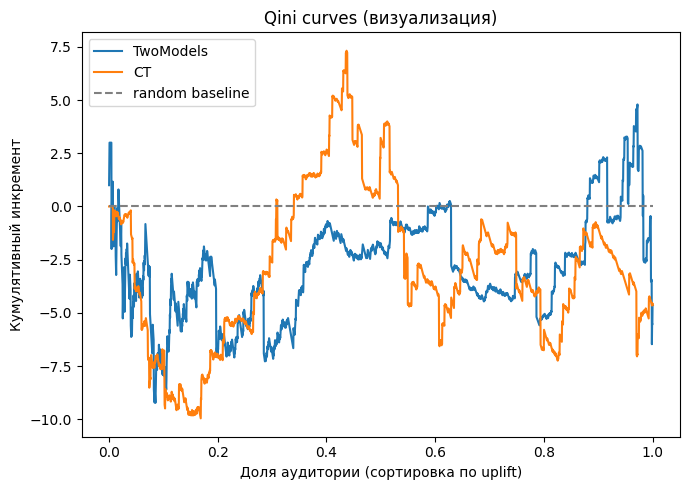

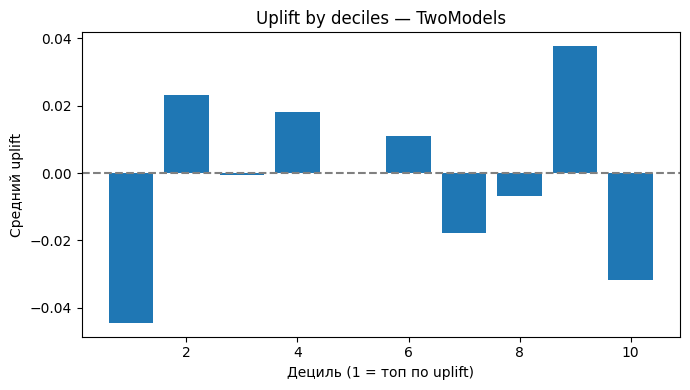

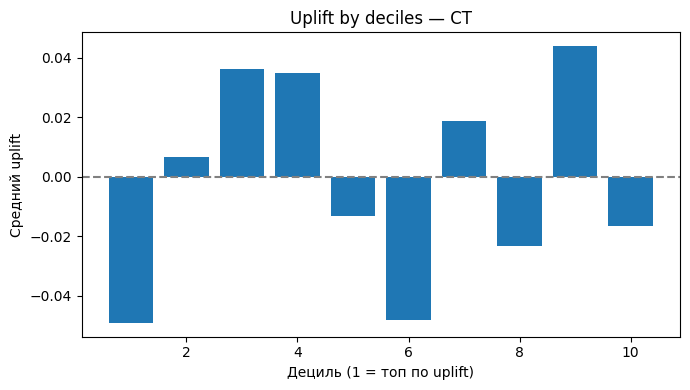

In [8]:
plt.figure(figsize=(7,5))
plot_qini_curve(y_te, uplift_tm, t_te, label="TwoModels")
plot_qini_curve(y_te, uplift_ct, t_te, label="CT")
plt.plot([0,1], [0, 0], '--', color='gray', label="random baseline")
plt.title("Qini curves (визуализация)")
plt.xlabel("Доля аудитории (сортировка по uplift)")
plt.ylabel("Кумулятивный инкремент")
plt.legend()
plt.tight_layout()
plt.show()

plot_uplift_by_deciles(y_te, uplift_tm, t_te, title="Uplift by deciles — TwoModels")
plot_uplift_by_deciles(y_te, uplift_ct, t_te, title="Uplift by deciles — CT")


In [9]:
FIG = Path("../reports/figures"); FIG.mkdir(parents=True, exist_ok=True)

plt.figure(figsize=(7,5))
plot_qini_curve(y_te, uplift_tm, t_te, label="TwoModels")
plot_qini_curve(y_te, uplift_ct, t_te, label="CT")
plt.plot([0,1], [0, 0], '--', color='gray', label="random baseline")
plt.title("Qini curves")
plt.xlabel("Доля аудитории")
plt.ylabel("Кумулятивный инкремент")
plt.legend()
plt.tight_layout()
plt.savefig(FIG / "qini_curves.png", dpi=150)
plt.close()

### Итоги по Uplift

- Метрики: Qini AUC ≈ 0, uplift@k колеблется, эффекта почти нет.

- Графики: Qini-кривые идут около baseline, uplift по децилям нестабилен.

- Причины: низкий базовый churn (3–4%), сильный дисбаланс, слабая информативность признаков.

Вывод: модели пока работают на уровне случайного выбора, но дают зацепки для таргетинга (в отдельных сегментах uplift положителен).

##### Перспективы:

- Генерация новых бизнес-признаков;

- Углублённый feature engineering;

- Сегментация клиентов;

- Более сложные модели uplift.